In [1]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [2]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

In [3]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [4]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [5]:
from datetime import datetime as dt
start = dt.now()
# process stuff

from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)
running_secs = (dt.now() - start).seconds

4999 0.049659691751003265


In [6]:
running_secs

210

Text(0, 0.5, 'Loss')

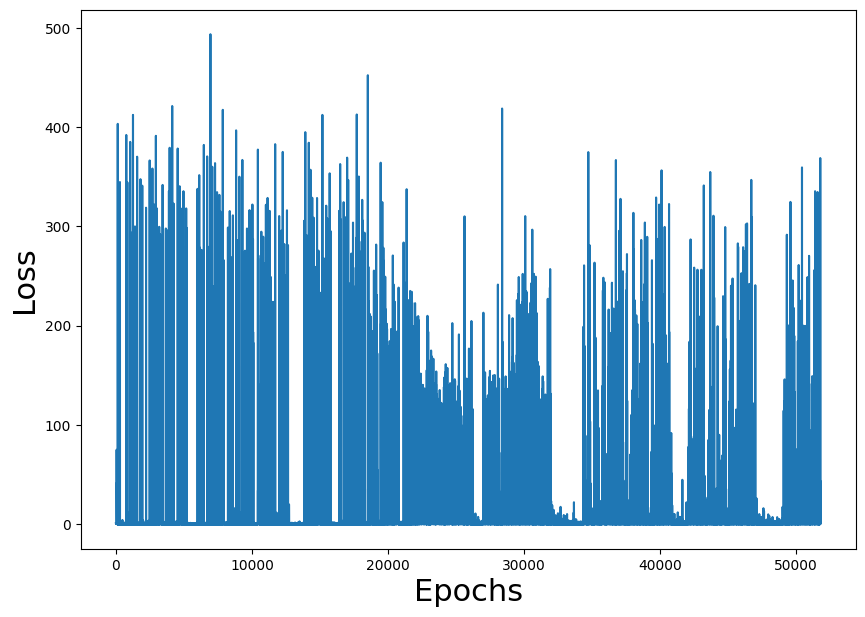

In [33]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [10]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 911
Win percentage: 91.10000000000001%


In [29]:
Q2

tensor([[  7.6886,   8.6525,   8.9984,   8.4438],
        [  7.5044,   6.6398,   5.0704,   7.5371],
        [ -3.2408,  -4.6099,  -3.6553,  -4.1843],
        [  2.0977,   2.1171,   3.5251,   1.8113],
        [  4.5025,   7.9673,   6.0294,   3.3335],
        [  8.1200,   7.8661,   7.6763,   9.0401],
        [  6.9875,   5.9203,   6.9667,   6.5736],
        [  8.8479,  10.1254,   9.6285,   7.1426],
        [ -1.4645,  -3.9167,  -3.1636,  -2.9974],
        [  6.1175,   7.1984,   5.6444,   8.1968],
        [  7.0204,   3.1510,   7.5273,   7.3282],
        [  8.0131,   3.1651,   4.8041,   7.9423],
        [  7.5992,   6.8641,   7.0770,   6.2407],
        [ -0.5191,   0.2134,   1.6659,   0.3888],
        [  3.0843,   4.3369,   2.0652,   2.0608],
        [  4.5028,   2.9741,   1.6627,   3.0429],
        [  0.0197,  -0.9127,  -1.6083,   0.0746],
        [  3.6201,   5.0542,   2.7797,   2.1789],
        [  7.8213,  10.1230,   6.4607,   6.2068],
        [  6.3412,   8.1921,   6.5029,   7.6329],


In [9]:
game.board.render_np().reshape(1,16)

ValueError: cannot reshape array of size 64 into shape (1,16)

In [30]:
action_batch

tensor([0., 3., 3., 1., 2., 3., 1., 2., 2., 3., 3., 3., 0., 1., 2., 1., 3., 0.,
        2., 1., 2., 1., 1., 3., 1., 3., 1., 3., 0., 3., 1., 1., 3., 3., 3., 1.,
        3., 2., 0., 3., 3., 2., 3., 3., 3., 0., 2., 1., 0., 2., 1., 0., 0., 3.,
        1., 1., 2., 3., 1., 1., 0., 0., 0., 2., 1., 1., 3., 1., 1., 1., 3., 2.,
        2., 2., 3., 0., 0., 3., 3., 2., 0., 3., 2., 3., 0., 2., 2., 1., 0., 2.,
        1., 0., 3., 2., 3., 2., 2., 3., 2., 2., 2., 0., 3., 1., 2., 0., 0., 1.,
        0., 2., 2., 0., 3., 2., 0., 0., 1., 2., 2., 2., 1., 2., 2., 3., 2., 2.,
        0., 0., 2., 3., 0., 0., 0., 3., 2., 3., 1., 3., 3., 3., 2., 1., 2., 2.,
        3., 1., 2., 2., 0., 1., 1., 2., 3., 0., 3., 3., 3., 1., 0., 2., 3., 1.,
        1., 2., 2., 3., 2., 2., 3., 2., 0., 2., 1., 2., 1., 0., 3., 0., 3., 0.,
        2., 1., 3., 3., 3., 0., 1., 3., 1., 0., 0., 1., 2., 3., 1., 0., 0., 2.,
        2., 1.])

In [8]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [49]:
torch.max(Q2,dim=1)[0][0].item()

8.998382568359375

In [24]:
count = 0
for rew in reward_batch:
    print(count)
    print(rew)
    count = count + 1

0
tensor(10.)
1
tensor(10.)
2
tensor(-1.)
3
tensor(-1.)
4
tensor(-1.)
5
tensor(10.)
6
tensor(10.)
7
tensor(-1.)
8
tensor(-1.)
9
tensor(10.)
10
tensor(10.)
11
tensor(-1.)
12
tensor(10.)
13
tensor(-1.)
14
tensor(-1.)
15
tensor(-1.)
16
tensor(-1.)
17
tensor(-1.)
18
tensor(-1.)
19
tensor(10.)
20
tensor(-1.)
21
tensor(-1.)
22
tensor(-1.)
23
tensor(-1.)
24
tensor(-1.)
25
tensor(-1.)
26
tensor(-1.)
27
tensor(-1.)
28
tensor(10.)
29
tensor(-1.)
30
tensor(-10.)
31
tensor(-1.)
32
tensor(-1.)
33
tensor(-1.)
34
tensor(10.)
35
tensor(-1.)
36
tensor(-1.)
37
tensor(10.)
38
tensor(-1.)
39
tensor(-1.)
40
tensor(-1.)
41
tensor(-1.)
42
tensor(-1.)
43
tensor(-1.)
44
tensor(10.)
45
tensor(-1.)
46
tensor(-1.)
47
tensor(-1.)
48
tensor(-1.)
49
tensor(-1.)
50
tensor(-1.)
51
tensor(-1.)
52
tensor(-1.)
53
tensor(-10.)
54
tensor(-1.)
55
tensor(-1.)
56
tensor(-1.)
57
tensor(-1.)
58
tensor(-1.)
59
tensor(10.)
60
tensor(-1.)
61
tensor(-1.)
62
tensor(-1.)
63
tensor(10.)
64
tensor(-1.)
65
tensor(-1.)
66
tensor(-1.)
67


In [26]:
done_batch

tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.])

In [31]:
reward_batch

tensor([ 10.,  10.,  -1.,  -1.,  -1.,  10.,  10.,  -1.,  -1.,  10.,  10.,  -1.,
         10.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  10.,  -1.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.,  10.,  -1., -10.,  -1.,  -1.,  -1.,  10.,  -1.,
         -1.,  10.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  10.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.,  -1., -10.,  -1.,  -1.,  -1.,  -1.,  -1.,  10.,
         -1.,  -1.,  -1.,  10.,  -1.,  -1.,  -1.,  10.,  -1.,  10.,  -1.,  -1.,
         -1.,  10.,  -1.,  -1.,  10.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
         10.,  -1.,  -1.,  -1.,  -1., -10.,  -1.,  10.,  -1., -10.,  -1.,  10.,
         -1.,  -1.,  -1.,  -1.,  10.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  10.,  -1.,
         -1.,  -1.,  10.,  -1.,  -1.,  -1.,  -1., -10.,  10.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  10.,  10.,  -1.,  -1.,  -1.,  10.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.,  10.,  1

In [34]:
state1_batch

tensor([[5.6684e-03, 5.9452e-03, 8.2582e-03,  ..., 2.5547e-03, 5.8613e-03,
         1.2410e-03],
        [1.0876e-03, 9.7840e-03, 8.3695e-03,  ..., 1.0199e-03, 1.2656e-03,
         4.9933e-03],
        [3.0775e-03, 7.8929e-03, 4.1766e-03,  ..., 6.3060e-03, 2.9159e-03,
         3.3696e-03],
        ...,
        [9.4258e-03, 3.9486e-03, 5.9031e-03,  ..., 1.1751e-03, 1.0055e+00,
         1.9106e-03],
        [9.9450e-04, 4.2433e-03, 5.2930e-03,  ..., 2.1951e-03, 3.0703e-03,
         5.1772e-03],
        [9.5054e-03, 5.4015e-04, 6.1510e-03,  ..., 1.8202e-03, 3.7972e-03,
         7.9087e-04]])

In [35]:
X

tensor([10.2290, 10.2763, -4.2084,  2.1970,  6.1872,  9.9508, 10.0740,  8.1998,
        -2.3949,  9.9406, 10.1043,  6.2563,  9.9168,  0.4747,  2.7833,  2.9396,
         0.0716,  3.6134,  8.2876,  9.9121,  6.2678,  7.9859,  4.4973,  4.9575,
         4.5894,  8.6225,  2.1414,  7.9032,  9.9664,  5.4113, -5.1362,  3.8700,
         2.1515,  3.5606, 10.0512,  8.0766,  5.4661,  9.9816,  4.5025,  4.1722,
         6.1262,  0.2899,  6.2482, -5.1387,  9.9488,  6.0615,  7.9731,  6.0695,
         5.9965,  4.7327,  7.9555,  4.5028,  4.0886, -5.9390, -4.4162, -3.2802,
         4.1802,  8.1011,  7.4891,  9.9462,  6.5907,  8.0194,  7.8269, 10.0144,
        -3.2295, -1.8830,  2.9873,  9.8886,  4.2014, 10.5469,  4.5379, -2.3739,
         8.2863,  9.9228,  8.1051,  2.1592,  9.9588,  7.8556,  7.8585,  7.9757,
         3.6414,  6.4600,  4.0984,  1.9831, 10.0113,  4.5995, -3.3487, -3.4697,
         2.5095, -7.2475,  3.0743,  9.9992,  0.4188, -6.0523,  1.9130, 10.1160,
         8.1136,  4.6129,  6.2248,  0.21

In [36]:
Y

tensor([10.0000, 10.0000, -3.9167,  2.1726,  6.1705, 10.0000, 10.0000,  8.1129,
        -2.3181, 10.0000, 10.0000,  6.2118, 10.0000,  0.4993,  2.9032,  3.0525,
        -0.9329,  3.5488,  8.1107, 10.0000,  6.2965,  7.8971,  4.5739,  4.7039,
         4.6012,  8.1359,  2.1578,  7.8998, 10.0000,  5.9173, -4.6282,  3.9755,
         2.1426,  3.3878, 10.0000,  8.0930,  5.9762, 10.0000,  4.5112,  4.2935,
         6.1728,  0.3063,  6.2600, -4.9850, 10.0000,  6.1299,  7.8680,  6.0823,
         6.1451,  4.6397,  7.9952,  4.5197,  4.4625, -6.0101, -4.3200, -3.4871,
         4.1577,  7.9375,  7.7809, 10.0000,  6.7602,  8.0696,  8.0495, 10.0000,
        -3.4298, -1.9760,  3.0591, 10.0000,  3.5330, 10.0000,  4.5609, -2.2909,
         8.2061, 10.0000,  8.1657,  2.1659, 10.0000,  7.9466,  7.9557,  7.9729,
         3.6716,  6.3348,  3.9660,  1.9753, 10.0000,  4.3219, -3.4163, -3.3735,
         2.5705, -7.3416,  3.0449, 10.0000,  0.4343, -6.0547,  1.9898, 10.0000,
         8.0666,  4.6214,  6.2216,  0.35

In [72]:
w, h = 9, 200
matrix = [[0 for x in range(w)] for y in range(h)] 

In [52]:
Q1[0][3].item()

6.5699872970581055

In [58]:
str(round(Q1[i][0].item(),3)) + "/" + str(Q1[i][1].item()) + "/" + str(Q1[i][2].item()) + "/" + str(Q1[i][3].item())

'4.999/6.939554691314697/6.828616142272949/9.940614700317383'

In [61]:
matrix[50][0]

0

In [73]:
for i in range(0, 200):
    matrix[i][0] = str(round(Q1[i][0].item(),2)) + "/" + str(round(Q1[i][1].item(),2)) + "/" + str(round(Q1[i][2].item(),2)) + "/" + str(round(Q1[i][3].item(),2))
    matrix[i][1] = str(round(Q2[i][0].item(),2)) + "/" + str(round(Q2[i][1].item(),2)) + "/" + str(round(Q2[i][2].item(),2)) + "/" + str(round(Q2[i][3].item(),2))
    matrix[i][2] = action_batch[i].item()
    matrix[i][3] = reward_batch[i].item()
    matrix[i][4] = done_batch[i].item()
    matrix[i][5] = torch.max(Q2,dim=1)[0][i].item()
    matrix[i][6] = X[i].item()
    matrix[i][7] = Y[i].item()
    matrix[i][8] = gamma

In [74]:
import pandas as pd
column_names = ["Q1_arr", "Q2_arr", "Action", "Reward", "Done", "Q_max", "X", "Y", "Gamma"
                ]
df = pd.DataFrame(matrix, columns = column_names)

In [75]:
df

,Q1_arr,Q2_arr,Action,Reward,Done,Q_max,X,Y,Gamma
0,10.23/8.87/7.88/6.57,7.69/8.65/9.0/8.44,0.0,10.0,1.0,8.998383,10.229005,10.000000,0.9
1,7.17/7.57/5.42/10.28,7.5/6.64/5.07/7.54,3.0,10.0,1.0,7.537056,10.276296,10.000000,0.9
2,-3.41/-10.31/-3.76/-4.21,-3.24/-4.61/-3.66/-4.18,3.0,-1.0,0.0,-3.240751,-4.208362,-3.916676,0.9
3,2.16/2.2/3.52/1.85,2.1/2.12/3.53/1.81,1.0,-1.0,0.0,3.525084,2.197031,2.172576,0.9
4,1.85/4.45/6.19/2.11,4.5/7.97/6.03/3.33,2.0,-1.0,0.0,7.967263,6.187174,6.170537,0.9
...,...,...,...,...,...,...,...,...,...
195,5.93/3.92/3.88/2.73,7.81/5.18/5.6/3.8,0.0,-1.0,0.0,7.812654,5.931213,6.031388,0.9
196,4.91/4.95/3.17/7.0,4.84/4.84/3.13/6.88,0.0,-1.0,0.0,6.877226,4.912088,5.189503,0.9
197,6.47/6.41/9.87/6.59,3.05/6.95/9.13/7.25,2.0,10.0,1.0,9.125730,9.872858,10.000000,0.9
198,9.92/5.48/6.18/7.78,6.51/5.7/6.05/7.98,2.0,-1.0,0.0,7.983006,6.179935,6.184705,0.9


In [77]:
Y.detach()

tensor([10.0000, 10.0000, -3.9167,  2.1726,  6.1705, 10.0000, 10.0000,  8.1129,
        -2.3181, 10.0000, 10.0000,  6.2118, 10.0000,  0.4993,  2.9032,  3.0525,
        -0.9329,  3.5488,  8.1107, 10.0000,  6.2965,  7.8971,  4.5739,  4.7039,
         4.6012,  8.1359,  2.1578,  7.8998, 10.0000,  5.9173, -4.6282,  3.9755,
         2.1426,  3.3878, 10.0000,  8.0930,  5.9762, 10.0000,  4.5112,  4.2935,
         6.1728,  0.3063,  6.2600, -4.9850, 10.0000,  6.1299,  7.8680,  6.0823,
         6.1451,  4.6397,  7.9952,  4.5197,  4.4625, -6.0101, -4.3200, -3.4871,
         4.1577,  7.9375,  7.7809, 10.0000,  6.7602,  8.0696,  8.0495, 10.0000,
        -3.4298, -1.9760,  3.0591, 10.0000,  3.5330, 10.0000,  4.5609, -2.2909,
         8.2061, 10.0000,  8.1657,  2.1659, 10.0000,  7.9466,  7.9557,  7.9729,
         3.6716,  6.3348,  3.9660,  1.9753, 10.0000,  4.3219, -3.4163, -3.3735,
         2.5705, -7.3416,  3.0449, 10.0000,  0.4343, -6.0547,  1.9898, 10.0000,
         8.0666,  4.6214,  6.2216,  0.35

In [81]:
loss = loss_fn(X, Y.detach())
loss

tensor(0.0699, grad_fn=<MseLossBackward0>)

In [102]:
>>> loss = torch.nn.MSELoss()
>>> input = torch.randn(3, 1, requires_grad=True)
>>> target = torch.randn(3, 1)
>>> output = loss(input, target)
output

tensor(0.1903, grad_fn=<MseLossBackward0>)

In [103]:
input

tensor([[-1.0910],
        [-0.0216],
        [ 0.9621]], requires_grad=True)

In [104]:
target

tensor([[-1.2999],
        [ 0.2746],
        [ 0.2991]])

In [105]:
x = (input - target) * (input - target)
(x[0] + x[1] + x[2]) / 3

tensor([0.1903], grad_fn=<DivBackward0>)

In [91]:
output

tensor(3.5240, grad_fn=<MseLossBackward0>)

In [109]:
state1_batch[0]

tensor([8.0048e-03, 8.4084e-03, 7.4567e-03, 8.7913e-03, 1.0004e+00, 4.1295e-03,
        9.0897e-03, 2.0910e-03, 4.5262e-03, 7.8988e-03, 6.2580e-03, 2.9863e-03,
        7.2840e-04, 2.6224e-03, 6.8965e-03, 2.3558e-03, 6.8499e-03, 6.0165e-03,
        7.8149e-03, 6.0311e-03, 4.3794e-03, 3.7353e-04, 5.8854e-03, 7.0085e-03,
        9.8530e-03, 1.0005e+00, 4.2308e-03, 4.5604e-03, 9.4608e-03, 7.8816e-04,
        8.2777e-03, 2.8267e-03, 7.4886e-03, 5.8596e-03, 3.9382e-03, 5.9753e-03,
        4.2056e-03, 4.2878e-03, 9.2090e-03, 1.0073e+00, 3.9433e-03, 3.4280e-03,
        5.1702e-03, 3.1414e-03, 5.8805e-03, 9.1367e-03, 3.3019e-03, 8.7954e-03,
        7.5328e-03, 4.9586e-03, 2.2932e-03, 5.7280e-03, 6.1478e-03, 7.4511e-03,
        6.1890e-03, 2.4583e-03, 3.5655e-04, 5.2322e-03, 1.6769e-03, 7.8480e-03,
        7.3710e-03, 3.2990e-03, 2.1420e-03, 1.0096e+00])